In [348]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
from datetime import timedelta
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV

In [345]:
df_chicago = pd.read_csv('../dataset/chicago_2018_clean.csv')
df_weather = pd.read_csv('../dataset/chicago_weather_2018_clean.csv')

# Disclaimer: When we later on talk about demand, we always mean the hourly demand
# Also the column 'Demand' which will be added later on, is representing the hourly demand

In [273]:
df_sorted = df_chicago.sort_values(by=['start_time'], ascending = [True])
#print(df_sorted['start_time'].iloc[380])
df_sorted.head(9)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration_per_trip,trip_time_in_hours
3212538,2018-01-01 00:12:00,2018-01-01 00:17:23,69,159,Damen Ave & Pierce Ave,Claremont Ave & Hirsch St,3304,Subscriber,0 days 00:05:23,0.089722
3212539,2018-01-01 00:41:35,2018-01-01 00:47:52,253,325,Winthrop Ave & Lawrence Ave,Clark St & Winnemac Ave (Temp),5367,Subscriber,0 days 00:06:17,0.104722
3212540,2018-01-01 00:44:46,2018-01-01 01:33:10,98,509,LaSalle St & Washington St,Troy St & North Ave,4599,Subscriber,0 days 00:48:24,0.806667
3212541,2018-01-01 00:53:10,2018-01-01 01:05:37,125,364,Rush St & Hubbard St,Larrabee St & Oak St,2302,Subscriber,0 days 00:12:27,0.207500
3212542,2018-01-01 00:53:37,2018-01-01 00:56:40,129,205,Blue Island Ave & 18th St,Paulina St & 18th St,3696,Subscriber,0 days 00:03:03,0.050833
3212543,2018-01-01 00:56:15,2018-01-01 01:00:41,304,299,Broadway & Waveland Ave,Halsted St & Roscoe St,6298,Subscriber,0 days 00:04:26,0.073889
3212544,2018-01-01 00:57:26,2018-01-01 01:02:40,164,174,Franklin St & Lake St,Canal St & Madison St,1169,Subscriber,0 days 00:05:14,0.087222
3212545,2018-01-01 01:00:29,2018-01-01 01:13:43,182,142,Wells St & Elm St,McClurg Ct & Erie St,6351,Subscriber,0 days 00:13:14,0.220556
3212546,2018-01-01 01:07:12,2018-01-01 01:31:53,99,99,Lake Shore Dr & Ohio St,Lake Shore Dr & Ohio St,1920,Customer,0 days 00:24:41,0.411389


In [274]:
#rename date_time column of df_weather in order to successfully merge system load and weather dataframe later on
df_weather.rename(columns = {'date_time':'start_time'}, inplace = True)
#convert now start_time column to datetime format in order to merge later on
df_weather['start_time'] = pd.to_datetime(df_weather['start_time']) #TODO: wetter datei nochmal neu holen
df_weather.head(20)

,start_time,max_temp,min_temp,precip
0,2018-01-01 00:00:00,-13.9,-13.9,0.0
1,2018-01-01 01:00:00,-15.0,-15.0,0.0
2,2018-01-01 02:00:00,-15.6,-15.6,0.0
3,2018-01-01 03:00:00,-16.7,-16.7,0.0
4,2018-01-01 04:00:00,-17.2,-17.2,0.0
5,2018-01-01 05:00:00,-17.8,-17.8,0.0
6,2018-01-01 06:00:00,-18.3,-18.3,0.0
7,2018-01-01 07:00:00,-19.4,-19.4,0.0
8,2018-01-01 08:00:00,-20.0,-20.0,0.0
9,2018-01-01 09:00:00,-20.6,-20.6,0.0


In [276]:
#we calculate the hourly system demand by summing up the number of biketrips started in one hour
df_sorted['start_time'] = pd.to_datetime(df_sorted['start_time'])
df_sorted['end_time'] = pd.to_datetime(df_sorted['end_time'])
df_load = df_sorted.groupby([pd.Grouper(key='start_time',freq='H')]).size().reset_index(name='Demand')
df_load

,start_time,Demand
0,2018-01-01 00:00:00,7
1,2018-01-01 01:00:00,14
2,2018-01-01 02:00:00,10
3,2018-01-01 03:00:00,2
4,2018-01-01 04:00:00,2
...,...,...
8755,2018-12-31 19:00:00,41
8756,2018-12-31 20:00:00,28
8757,2018-12-31 21:00:00,22
8758,2018-12-31 22:00:00,25


In [278]:
# merge Demand dataframe with weather dataframe
# calculate average temperature within the hour to check correlation with demand later on

df_load_weather = pd.merge(df_load, df_weather, on='start_time')
#calculate average ter
df_load_weather['avg_temp'] = (df_load_weather['max_temp'] + df_load_weather['min_temp'])/2
#since we only inspect the average temperature in the hour, we can drop the max_temp and min_temp columns
df_load_weather.head(10)

,start_time,Demand,max_temp,min_temp,precip,avg_temp
0,2018-01-01 00:00:00,7,-13.9,-13.9,0.0,-13.9
1,2018-01-01 01:00:00,14,-15.0,-15.0,0.0,-15.0
2,2018-01-01 02:00:00,10,-15.6,-15.6,0.0,-15.6
3,2018-01-01 03:00:00,2,-16.7,-16.7,0.0,-16.7
4,2018-01-01 04:00:00,2,-17.2,-17.2,0.0,-17.2
5,2018-01-01 05:00:00,3,-17.8,-17.8,0.0,-17.8
6,2018-01-01 06:00:00,5,-18.3,-18.3,0.0,-18.3
7,2018-01-01 07:00:00,5,-19.4,-19.4,0.0,-19.4
8,2018-01-01 08:00:00,7,-20.0,-20.0,0.0,-20.0
9,2018-01-01 09:00:00,10,-20.6,-20.6,0.0,-20.6


In [279]:
df_load_weather.drop(['max_temp', 'min_temp'], axis = 1, inplace = True)
df_load_weather.head(10)

,start_time,Demand,precip,avg_temp
0,2018-01-01 00:00:00,7,0.0,-13.9
1,2018-01-01 01:00:00,14,0.0,-15.0
2,2018-01-01 02:00:00,10,0.0,-15.6
3,2018-01-01 03:00:00,2,0.0,-16.7
4,2018-01-01 04:00:00,2,0.0,-17.2
5,2018-01-01 05:00:00,3,0.0,-17.8
6,2018-01-01 06:00:00,5,0.0,-18.3
7,2018-01-01 07:00:00,5,0.0,-19.4
8,2018-01-01 08:00:00,7,0.0,-20.0
9,2018-01-01 09:00:00,10,0.0,-20.6


In [280]:
# create new column for only the hour of the starttime
# since calculating the correlation between a int object (Demand) and a datetime (start_time) object is tricky, 
# we save the hour of the starting time in a new column to make this operation easier

df_load_weather['start_hour'] = df_load_weather['start_time'].dt.hour
df_load_weather.head(25)

,start_time,Demand,precip,avg_temp,start_hour
0,2018-01-01 00:00:00,7,0.0,-13.9,0
1,2018-01-01 01:00:00,14,0.0,-15.0,1
2,2018-01-01 02:00:00,10,0.0,-15.6,2
3,2018-01-01 03:00:00,2,0.0,-16.7,3
4,2018-01-01 04:00:00,2,0.0,-17.2,4
5,2018-01-01 05:00:00,3,0.0,-17.8,5
6,2018-01-01 06:00:00,5,0.0,-18.3,6
7,2018-01-01 07:00:00,5,0.0,-19.4,7
8,2018-01-01 08:00:00,7,0.0,-20.0,8
9,2018-01-01 09:00:00,10,0.0,-20.6,9


In [281]:
# create new column for start_month
# same as for start_hour: we want to check the correlation between the month the trips are in and the demand
df_load_weather['start_month'] = df_load_weather['start_time'].dt.month
df_load_weather.head(10)

,start_time,Demand,precip,avg_temp,start_hour,start_month
0,2018-01-01 00:00:00,7,0.0,-13.9,0,1
1,2018-01-01 01:00:00,14,0.0,-15.0,1,1
2,2018-01-01 02:00:00,10,0.0,-15.6,2,1
3,2018-01-01 03:00:00,2,0.0,-16.7,3,1
4,2018-01-01 04:00:00,2,0.0,-17.2,4,1
5,2018-01-01 05:00:00,3,0.0,-17.8,5,1
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1
7,2018-01-01 07:00:00,5,0.0,-19.4,7,1
8,2018-01-01 08:00:00,7,0.0,-20.0,8,1
9,2018-01-01 09:00:00,10,0.0,-20.6,9,1


In [282]:
# holiday check
# following days where federal holidays in Illinois (the state chicago is located in):
# 01.01, 15.01, 12.02, 19.02, 05.03, 28.05, 04.07, 03.09, 08.10, 06.11, 12.11, 22.11, 23.11, 05.12, 24.12, 25.12
# source: TODO noch hinzufügen

holidays = np.array([
    datetime.date(2018,1,1),
    datetime.date(2018,1,15),
    datetime.date(2018,2,12),
    datetime.date(2018,2,19),
    datetime.date(2018,3,5),
    datetime.date(2018,5,28),
    datetime.date(2018,7,4),
    datetime.date(2018,9,3),
    datetime.date(2018,10,8),
    datetime.date(2018,11,6),
    datetime.date(2018,11,12),
    datetime.date(2018,11,22),
    datetime.date(2018,11,23),
    datetime.date(2018,12,5),
    datetime.date(2018,12,24),
    datetime.date(2018,12,25),
])
print(holidays)

#conditions = [df_load_weather['star_time'].date()= ]

[datetime.date(2018, 1, 1) datetime.date(2018, 1, 15)
 datetime.date(2018, 2, 12) datetime.date(2018, 2, 19)
 datetime.date(2018, 3, 5) datetime.date(2018, 5, 28)
 datetime.date(2018, 7, 4) datetime.date(2018, 9, 3)
 datetime.date(2018, 10, 8) datetime.date(2018, 11, 6)
 datetime.date(2018, 11, 12) datetime.date(2018, 11, 22)
 datetime.date(2018, 11, 23) datetime.date(2018, 12, 5)
 datetime.date(2018, 12, 24) datetime.date(2018, 12, 25)]


In [299]:
#create new column in df_load_weather to signal if day was a holiday
#Holiday column is important so we can later check, if there is a correlation between holidays and Demand
df_load_weather['start_time'] = pd.to_datetime(df_load_weather['start_time'])
df_load_weather['isHoliday'] = df_load_weather['start_time'].dt.date.isin(holidays)

# since we want to make sure that the correlation is calculated properly, we transform the currently boolean values
# of isHoliday to int values: 1 = this date was a holiday; 2 = this date wasn't a holiday
df_load_weather['isHoliday'] = df_load_weather['isHoliday'].astype(int)

df_load_weather.head(10)

,start_time,Demand,precip,avg_temp,start_hour,start_month,isHoliday
0,2018-01-01 00:00:00,7,0.0,-13.9,0,1,1
1,2018-01-01 01:00:00,14,0.0,-15.0,1,1,1
2,2018-01-01 02:00:00,10,0.0,-15.6,2,1,1
3,2018-01-01 03:00:00,2,0.0,-16.7,3,1,1
4,2018-01-01 04:00:00,2,0.0,-17.2,4,1,1
5,2018-01-01 05:00:00,3,0.0,-17.8,5,1,1
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1,1
7,2018-01-01 07:00:00,5,0.0,-19.4,7,1,1
8,2018-01-01 08:00:00,7,0.0,-20.0,8,1,1
9,2018-01-01 09:00:00,10,0.0,-20.6,9,1,1


In [338]:
# Create new column 'day_of_Week' in df_load_weather to determine, which weekday/weekend-day it was at this date
# Crate dummy-variables to symbolize differnt days of the week
# Explain Indizes: 1=Monday, 2=Tuesday, 3=Wednesday, 4=Thursday, 5=Friday, 6=Saturday, 7=Sunday
# Will be used later to check correlation between weekdays and system demand

df_load_weather['day_of_Week'] = df_load_weather['start_time'].dt.isocalendar().day
df_load_weather.head(500)


,start_time,Demand,precip,avg_temp,start_hour,start_month,isHoliday,day_of_Week,season,in_rush_Hour,prev_Demand
0,2018-01-01 00:00:00,7,0.0,-13.90,0,1,1,1,1,0,NaN
1,2018-01-01 01:00:00,14,0.0,-15.00,1,1,1,1,1,0,7.0
2,2018-01-01 02:00:00,10,0.0,-15.60,2,1,1,1,1,0,14.0
3,2018-01-01 03:00:00,2,0.0,-16.70,3,1,1,1,1,0,10.0
4,2018-01-01 04:00:00,2,0.0,-17.20,4,1,1,1,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
495,2018-01-21 15:00:00,222,0.0,4.40,15,1,0,7,1,0,254.0
496,2018-01-21 16:00:00,182,0.0,4.70,16,1,0,7,1,1,222.0
497,2018-01-21 17:00:00,167,0.0,5.00,17,1,0,7,1,1,182.0
498,2018-01-21 18:00:00,140,0.0,6.40,18,1,0,7,1,1,167.0


In [301]:
# Create new column: season
# We later want to check the correlation between the season and the demand
# Create Dummy-Variables to symbolize different seasons
# Indizes Explanation: 1: Winter {Dec, Jan, Feb}; 2: Spring {Mar, April, May}; 3: Summer {June, July, Aug}; 4: Autumn {Sep, Oct, Nov}
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

monthToSeason = dict(zip(range(1,13), seasons))

df_load_weather['season'] = df_load_weather['start_time'].dt.month.map(monthToSeason)
df_load_weather.head(7000)

,start_time,Demand,precip,avg_temp,start_hour,start_month,isHoliday,day_of_Week,season
0,2018-01-01 00:00:00,7,0.0,-13.9,0,1,1,1,1
1,2018-01-01 01:00:00,14,0.0,-15.0,1,1,1,1,1
2,2018-01-01 02:00:00,10,0.0,-15.6,2,1,1,1,1
3,2018-01-01 03:00:00,2,0.0,-16.7,3,1,1,1,1
4,2018-01-01 04:00:00,2,0.0,-17.2,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...
6995,2018-10-19 11:00:00,327,0.0,7.8,11,10,0,5,4
6996,2018-10-19 12:00:00,314,0.0,8.3,12,10,0,5,4
6997,2018-10-19 13:00:00,282,0.0,8.9,13,10,0,5,4
6998,2018-10-19 14:00:00,302,0.0,9.4,14,10,0,5,4


In [302]:
# Create new column for possible feature: rush_Hour
# We will check later, if a correlatio between datasets in the rush_Hour and the Demand exists
# Rushhour in chicago is between (06:00am and 08:00) am and (04:00pm and 06:00pm)


df_load_weather['in_rush_Hour'] = False
df_load_weather['in_rush_Hour'] = np.where((df_load_weather['start_time'].dt.time.ge(datetime.time(6,0,0)) & df_load_weather['start_time'].dt.time.le(datetime.time(8,0,0)))
                                              | (df_load_weather['start_time'].dt.time.ge(datetime.time(16,0,0)) & df_load_weather['start_time'].dt.time.le(datetime.time(18,0,0))),1,0
                                          
                                          )



In [303]:
df_load_weather.head(25)

,start_time,Demand,precip,avg_temp,start_hour,start_month,isHoliday,day_of_Week,season,in_rush_Hour
0,2018-01-01 00:00:00,7,0.0,-13.9,0,1,1,1,1,0
1,2018-01-01 01:00:00,14,0.0,-15.0,1,1,1,1,1,0
2,2018-01-01 02:00:00,10,0.0,-15.6,2,1,1,1,1,0
3,2018-01-01 03:00:00,2,0.0,-16.7,3,1,1,1,1,0
4,2018-01-01 04:00:00,2,0.0,-17.2,4,1,1,1,1,0
5,2018-01-01 05:00:00,3,0.0,-17.8,5,1,1,1,1,0
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1,1,1,1,1
7,2018-01-01 07:00:00,5,0.0,-19.4,7,1,1,1,1,1
8,2018-01-01 08:00:00,7,0.0,-20.0,8,1,1,1,1,1
9,2018-01-01 09:00:00,10,0.0,-20.6,9,1,1,1,1,0


In [304]:
#Create new column prev_Demand to later check if there is a correlation between the demand of the previous hour and the current one

df_load_weather['prev_Demand'] = df_load_weather['Demand'].shift()
df_load_weather.head(10)


,start_time,Demand,precip,avg_temp,start_hour,start_month,isHoliday,day_of_Week,season,in_rush_Hour,prev_Demand
0,2018-01-01 00:00:00,7,0.0,-13.9,0,1,1,1,1,0,NaN
1,2018-01-01 01:00:00,14,0.0,-15.0,1,1,1,1,1,0,7.0
2,2018-01-01 02:00:00,10,0.0,-15.6,2,1,1,1,1,0,14.0
3,2018-01-01 03:00:00,2,0.0,-16.7,3,1,1,1,1,0,10.0
4,2018-01-01 04:00:00,2,0.0,-17.2,4,1,1,1,1,0,2.0
5,2018-01-01 05:00:00,3,0.0,-17.8,5,1,1,1,1,0,2.0
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1,1,1,1,1,3.0
7,2018-01-01 07:00:00,5,0.0,-19.4,7,1,1,1,1,1,5.0
8,2018-01-01 08:00:00,7,0.0,-20.0,8,1,1,1,1,1,5.0
9,2018-01-01 09:00:00,10,0.0,-20.6,9,1,1,1,1,0,7.0


In [372]:
# Create new column prev_Demand2
# We found that the correlation between the Demand one hour before the inspected hour was so high (ca 0.85) we will
# also check if the demand two hours ago also has such an outstanding correlation with the demand

df_load_weather['prev_Demand2'] = df_load_weather['prev_Demand'].shift()
df_load_weather.head(10)


,start_time,Demand,precip,avg_temp,start_hour,start_month,isHoliday,day_of_Week,season,in_rush_Hour,prev_Demand,prev_Demand2
0,2018-01-01 00:00:00,7,0.0,-13.9,0,1,1,1,1,0,NaN,NaN
1,2018-01-01 01:00:00,14,0.0,-15.0,1,1,1,1,1,0,7.0,NaN
2,2018-01-01 02:00:00,10,0.0,-15.6,2,1,1,1,1,0,14.0,7.0
3,2018-01-01 03:00:00,2,0.0,-16.7,3,1,1,1,1,0,10.0,14.0
4,2018-01-01 04:00:00,2,0.0,-17.2,4,1,1,1,1,0,2.0,10.0
5,2018-01-01 05:00:00,3,0.0,-17.8,5,1,1,1,1,0,2.0,2.0
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1,1,1,1,1,3.0,2.0
7,2018-01-01 07:00:00,5,0.0,-19.4,7,1,1,1,1,1,5.0,3.0
8,2018-01-01 08:00:00,7,0.0,-20.0,8,1,1,1,1,1,5.0,5.0
9,2018-01-01 09:00:00,10,0.0,-20.6,9,1,1,1,1,0,7.0,5.0


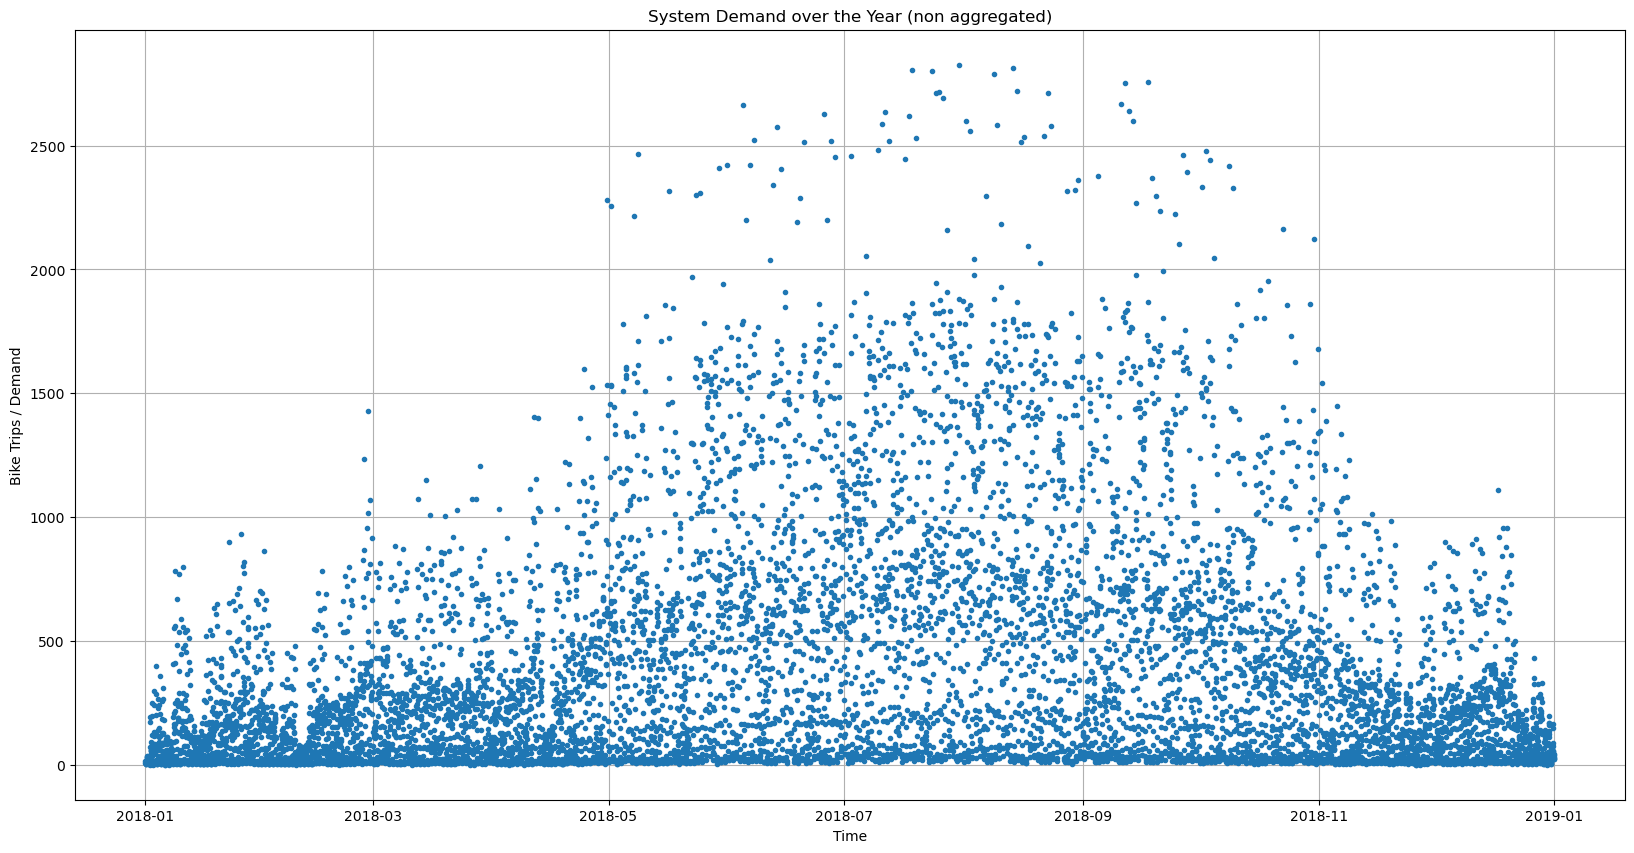

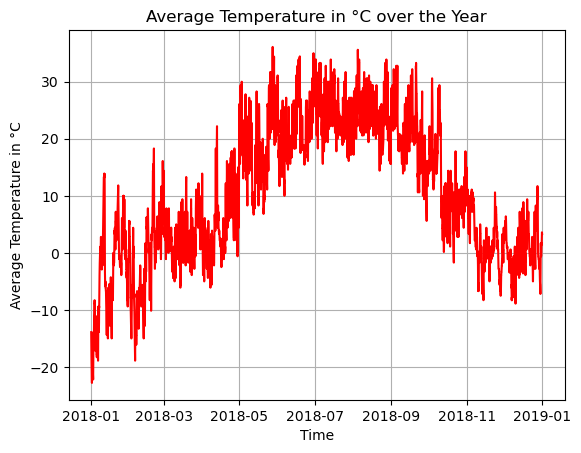

In [324]:
#to visualize our system demand, we create a plot
plt.plot(df_load_weather['start_time'], df_load_weather['Demand'], '.')
plt.title('System Demand over the Year (non aggregated)')
plt.xlabel('Time')
plt.ylabel('Bike Trips / Demand')
plt.grid(True)

plt.gcf().set_size_inches(20,10)
plt.show()

plt.plot(df_load_weather['start_time'],df_load_weather['avg_temp'], "r-")
plt.title('Average Temperature in °C over the Year')
plt.xlabel('Time')
plt.ylabel('Average Temperature in °C')
plt.grid(True)
plt.show()


In [374]:
# Feature Selection

# We start by performing a Lasso (L1 regularization) regression on our dataset, in order to obtain the importance
# of our features

#We start calculating the Pearson's correlation of each column with the demand to determine, which features
# are actually worth keeping for the regression

In [368]:
# First of all we split the data into our training and testing data, since we only compute our correlation
# and later regression also on our training data

# trying lasso regression for eliminating useless features and avoid overfitting



# x are out features
X = df_load_weather.drop('Demand', axis = 1)

# setting start_time as index, data is saved in start_day and start_month
# regression does not work with datetime objects, which is why we only save it as index and the acutal data (day, month, hour)
# as integer

X.set_index('start_time',inplace = True)
#print(X)

#X['start_time'] = pd.to_datetime(X['start_time'])
# y is our label
y = df_load_weather['Demand']

#splitting data into training and testing data, with testing data being 30% of our dataset
#random_state just a variable for randomizing which values are used for training and which are used for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# since lasso regression puts a lot of penalty on high magnitudes of features, scaling our features is essential
# in order to obtain precise results
# Normalizing of features: 

pipeline = Pipeline([('scaler',StandardScaler()),
                    ('model', Lasso())
                     ])

# for finding the optimal value for lamda (also called alpha in a lot of literature) we utilize a Grid Search

search = GridSearchCV (pipeline,
                      {'model__alpha': np.arange(0.1, 100, 0.1)},
                      cv = 5, scoring = "neg_mean_squared_error", verbose=3
                      )

# when increasing the lambda range from 10 to 100, the optimal value remains at 0.1
# we can conclude that the optimal lambda value for this data set is indeed 0.1 => very limited regularization

search.fit(X_train, y_train)
search.best_params_


Fitting 5 folds for each of 999 candidates, totalling 4995 fits
[CV 1/5] END .............model__alpha=0.1;, score=-41722.515 total time=   0.0s
[CV 2/5] END .............model__alpha=0.1;, score=-53105.077 total time=   0.0s
[CV 3/5] END .............model__alpha=0.1;, score=-50069.417 total time=   0.0s
[CV 4/5] END .............model__alpha=0.1;, score=-50176.643 total time=   0.0s
[CV 5/5] END .............model__alpha=0.1;, score=-48953.866 total time=   0.0s
[CV 1/5] END .............model__alpha=0.2;, score=-41717.220 total time=   0.0s
[CV 2/5] END .............model__alpha=0.2;, score=-53113.678 total time=   0.0s
[CV 3/5] END .............model__alpha=0.2;, score=-50058.179 total time=   0.0s
[CV 4/5] END .............model__alpha=0.2;, score=-50183.594 total time=   0.0s
[CV 5/5] END .............model__alpha=0.2;, score=-48955.474 total time=   0.0s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-41712.175 total time=   0.0s
[CV 2/5] END model__alpha=0.30000000000000

[CV 3/5] END .............model__alpha=2.1;, score=-49881.704 total time=   0.0s
[CV 4/5] END .............model__alpha=2.1;, score=-50350.152 total time=   0.0s
[CV 5/5] END .............model__alpha=2.1;, score=-49019.765 total time=   0.0s
[CV 1/5] END .............model__alpha=2.2;, score=-41643.233 total time=   0.0s
[CV 2/5] END .............model__alpha=2.2;, score=-53304.782 total time=   0.0s
[CV 3/5] END .............model__alpha=2.2;, score=-49873.336 total time=   0.0s
[CV 4/5] END .............model__alpha=2.2;, score=-50360.262 total time=   0.0s
[CV 5/5] END .............model__alpha=2.2;, score=-49024.984 total time=   0.0s
[CV 1/5] END model__alpha=2.3000000000000003;, score=-41640.304 total time=   0.0s
[CV 2/5] END model__alpha=2.3000000000000003;, score=-53314.837 total time=   0.0s
[CV 3/5] END model__alpha=2.3000000000000003;, score=-49865.132 total time=   0.0s
[CV 4/5] END model__alpha=2.3000000000000003;, score=-50370.530 total time=   0.0s
[CV 5/5] END model__

[CV 1/5] END model__alpha=4.3999999999999995;, score=-41601.205 total time=   0.0s
[CV 2/5] END model__alpha=4.3999999999999995;, score=-53534.424 total time=   0.0s
[CV 3/5] END model__alpha=4.3999999999999995;, score=-49730.498 total time=   0.0s
[CV 4/5] END model__alpha=4.3999999999999995;, score=-50610.952 total time=   0.0s
[CV 5/5] END model__alpha=4.3999999999999995;, score=-49187.752 total time=   0.0s
[CV 1/5] END .............model__alpha=4.5;, score=-41600.293 total time=   0.0s
[CV 2/5] END .............model__alpha=4.5;, score=-53543.644 total time=   0.0s
[CV 3/5] END .............model__alpha=4.5;, score=-49725.877 total time=   0.0s
[CV 4/5] END .............model__alpha=4.5;, score=-50623.460 total time=   0.0s
[CV 5/5] END .............model__alpha=4.5;, score=-49196.105 total time=   0.0s
[CV 1/5] END .............model__alpha=4.6;, score=-41599.505 total time=   0.0s
[CV 2/5] END .............model__alpha=4.6;, score=-53552.956 total time=   0.0s
[CV 3/5] END .....

[CV 5/5] END .............model__alpha=6.4;, score=-49339.098 total time=   0.0s
[CV 1/5] END .............model__alpha=6.5;, score=-41587.745 total time=   0.0s
[CV 2/5] END .............model__alpha=6.5;, score=-53713.426 total time=   0.0s
[CV 3/5] END .............model__alpha=6.5;, score=-49630.922 total time=   0.0s
[CV 4/5] END .............model__alpha=6.5;, score=-50896.852 total time=   0.0s
[CV 5/5] END .............model__alpha=6.5;, score=-49345.753 total time=   0.0s
[CV 1/5] END .............model__alpha=6.6;, score=-41587.716 total time=   0.0s
[CV 2/5] END .............model__alpha=6.6;, score=-53721.731 total time=   0.0s
[CV 3/5] END .............model__alpha=6.6;, score=-49625.674 total time=   0.0s
[CV 4/5] END .............model__alpha=6.6;, score=-50911.464 total time=   0.0s
[CV 5/5] END .............model__alpha=6.6;, score=-49352.470 total time=   0.0s
[CV 1/5] END .............model__alpha=6.7;, score=-41587.775 total time=   0.0s
[CV 2/5] END .............mo

[CV 2/5] END .............model__alpha=8.6;, score=-53902.708 total time=   0.0s
[CV 3/5] END .............model__alpha=8.6;, score=-49535.930 total time=   0.0s
[CV 4/5] END .............model__alpha=8.6;, score=-51152.643 total time=   0.0s
[CV 5/5] END .............model__alpha=8.6;, score=-49499.743 total time=   0.0s
[CV 1/5] END .............model__alpha=8.7;, score=-41585.624 total time=   0.0s
[CV 2/5] END .............model__alpha=8.7;, score=-53912.500 total time=   0.0s
[CV 3/5] END .............model__alpha=8.7;, score=-49532.203 total time=   0.0s
[CV 4/5] END .............model__alpha=8.7;, score=-51163.153 total time=   0.0s
[CV 5/5] END .............model__alpha=8.7;, score=-49507.753 total time=   0.0s
[CV 1/5] END .............model__alpha=8.8;, score=-41586.167 total time=   0.0s
[CV 2/5] END .............model__alpha=8.8;, score=-53922.362 total time=   0.0s
[CV 3/5] END .............model__alpha=8.8;, score=-49528.548 total time=   0.0s
[CV 4/5] END .............mo

[CV 3/5] END ............model__alpha=10.8;, score=-49470.667 total time=   0.0s
[CV 4/5] END ............model__alpha=10.8;, score=-51395.528 total time=   0.0s
[CV 5/5] END ............model__alpha=10.8;, score=-49641.097 total time=   0.0s
[CV 1/5] END ............model__alpha=10.9;, score=-41612.261 total time=   0.0s
[CV 2/5] END ............model__alpha=10.9;, score=-54145.216 total time=   0.0s
[CV 3/5] END ............model__alpha=10.9;, score=-49468.533 total time=   0.0s
[CV 4/5] END ............model__alpha=10.9;, score=-51407.152 total time=   0.0s
[CV 5/5] END ............model__alpha=10.9;, score=-49647.253 total time=   0.0s
[CV 1/5] END ............model__alpha=11.0;, score=-41614.203 total time=   0.0s
[CV 2/5] END ............model__alpha=11.0;, score=-54154.927 total time=   0.0s
[CV 3/5] END ............model__alpha=11.0;, score=-49466.471 total time=   0.0s
[CV 4/5] END ............model__alpha=11.0;, score=-51418.999 total time=   0.0s
[CV 5/5] END ............mod

[CV 3/5] END ............model__alpha=13.0;, score=-49423.870 total time=   0.0s
[CV 4/5] END ............model__alpha=13.0;, score=-51663.096 total time=   0.0s
[CV 5/5] END ............model__alpha=13.0;, score=-49787.023 total time=   0.0s
[CV 1/5] END ............model__alpha=13.1;, score=-41669.709 total time=   0.0s
[CV 2/5] END ............model__alpha=13.1;, score=-54370.343 total time=   0.0s
[CV 3/5] END ............model__alpha=13.1;, score=-49421.934 total time=   0.0s
[CV 4/5] END ............model__alpha=13.1;, score=-51675.831 total time=   0.0s
[CV 5/5] END ............model__alpha=13.1;, score=-49794.179 total time=   0.0s
[CV 1/5] END model__alpha=13.200000000000001;, score=-41673.053 total time=   0.0s
[CV 2/5] END model__alpha=13.200000000000001;, score=-54381.160 total time=   0.0s
[CV 3/5] END model__alpha=13.200000000000001;, score=-49420.049 total time=   0.0s
[CV 4/5] END model__alpha=13.200000000000001;, score=-51688.617 total time=   0.0s
[CV 5/5] END model__

[CV 1/5] END model__alpha=15.200000000000001;, score=-41751.843 total time=   0.0s
[CV 2/5] END model__alpha=15.200000000000001;, score=-54608.087 total time=   0.0s
[CV 3/5] END model__alpha=15.200000000000001;, score=-49393.178 total time=   0.0s
[CV 4/5] END model__alpha=15.200000000000001;, score=-51954.948 total time=   0.0s
[CV 5/5] END model__alpha=15.200000000000001;, score=-49954.957 total time=   0.0s
[CV 1/5] END ............model__alpha=15.3;, score=-41756.279 total time=   0.0s
[CV 2/5] END ............model__alpha=15.3;, score=-54619.962 total time=   0.0s
[CV 3/5] END ............model__alpha=15.3;, score=-49392.376 total time=   0.0s
[CV 4/5] END ............model__alpha=15.3;, score=-51968.795 total time=   0.0s
[CV 5/5] END ............model__alpha=15.3;, score=-49963.112 total time=   0.0s
[CV 1/5] END ............model__alpha=15.4;, score=-41760.763 total time=   0.0s
[CV 2/5] END ............model__alpha=15.4;, score=-54631.888 total time=   0.0s
[CV 3/5] END .....

[CV 3/5] END model__alpha=17.200000000000003;, score=-49386.921 total time=   0.0s
[CV 4/5] END model__alpha=17.200000000000003;, score=-52241.526 total time=   0.0s
[CV 5/5] END model__alpha=17.200000000000003;, score=-50126.724 total time=   0.0s
[CV 1/5] END ............model__alpha=17.3;, score=-41854.890 total time=   0.0s
[CV 2/5] END ............model__alpha=17.3;, score=-54868.037 total time=   0.0s
[CV 3/5] END ............model__alpha=17.3;, score=-49387.150 total time=   0.0s
[CV 4/5] END ............model__alpha=17.3;, score=-52256.387 total time=   0.0s
[CV 5/5] END ............model__alpha=17.3;, score=-50135.790 total time=   0.0s
[CV 1/5] END model__alpha=17.400000000000002;, score=-41860.315 total time=   0.0s
[CV 2/5] END model__alpha=17.400000000000002;, score=-54880.969 total time=   0.0s
[CV 3/5] END model__alpha=17.400000000000002;, score=-49387.429 total time=   0.0s
[CV 4/5] END model__alpha=17.400000000000002;, score=-52271.298 total time=   0.0s
[CV 5/5] END m

[CV 3/5] END model__alpha=19.200000000000003;, score=-49401.277 total time=   0.0s
[CV 4/5] END model__alpha=19.200000000000003;, score=-52548.347 total time=   0.0s
[CV 5/5] END model__alpha=19.200000000000003;, score=-50316.677 total time=   0.0s
[CV 1/5] END model__alpha=19.300000000000004;, score=-41972.329 total time=   0.0s
[CV 2/5] END model__alpha=19.300000000000004;, score=-55136.249 total time=   0.0s
[CV 3/5] END model__alpha=19.300000000000004;, score=-49402.535 total time=   0.0s
[CV 4/5] END model__alpha=19.300000000000004;, score=-52564.219 total time=   0.0s
[CV 5/5] END model__alpha=19.300000000000004;, score=-50326.652 total time=   0.0s
[CV 1/5] END model__alpha=19.400000000000002;, score=-41978.695 total time=   0.0s
[CV 2/5] END model__alpha=19.400000000000002;, score=-55150.188 total time=   0.0s
[CV 3/5] END model__alpha=19.400000000000002;, score=-49403.846 total time=   0.0s
[CV 4/5] END model__alpha=19.400000000000002;, score=-52580.141 total time=   0.0s
[CV 

[CV 3/5] END model__alpha=21.200000000000003;, score=-49436.243 total time=   0.0s
[CV 4/5] END model__alpha=21.200000000000003;, score=-52858.751 total time=   0.0s
[CV 5/5] END model__alpha=21.200000000000003;, score=-50524.814 total time=   0.0s
[CV 1/5] END model__alpha=21.300000000000004;, score=-42108.589 total time=   0.0s
[CV 2/5] END model__alpha=21.300000000000004;, score=-55424.599 total time=   0.0s
[CV 3/5] END model__alpha=21.300000000000004;, score=-49438.532 total time=   0.0s
[CV 4/5] END model__alpha=21.300000000000004;, score=-52873.541 total time=   0.0s
[CV 5/5] END model__alpha=21.300000000000004;, score=-50535.698 total time=   0.0s
[CV 1/5] END model__alpha=21.400000000000002;, score=-42115.896 total time=   0.0s
[CV 2/5] END model__alpha=21.400000000000002;, score=-55439.545 total time=   0.0s
[CV 3/5] END model__alpha=21.400000000000002;, score=-49440.873 total time=   0.0s
[CV 4/5] END model__alpha=21.400000000000002;, score=-52888.377 total time=   0.0s
[CV 

[CV 1/5] END model__alpha=23.300000000000004;, score=-42242.282 total time=   0.0s
[CV 2/5] END model__alpha=23.300000000000004;, score=-55718.462 total time=   0.0s
[CV 3/5] END model__alpha=23.300000000000004;, score=-49495.143 total time=   0.0s
[CV 4/5] END model__alpha=23.300000000000004;, score=-53179.014 total time=   0.0s
[CV 5/5] END model__alpha=23.300000000000004;, score=-50762.926 total time=   0.0s
[CV 1/5] END model__alpha=23.400000000000002;, score=-42248.647 total time=   0.0s
[CV 2/5] END model__alpha=23.400000000000002;, score=-55732.799 total time=   0.0s
[CV 3/5] END model__alpha=23.400000000000002;, score=-49498.514 total time=   0.0s
[CV 4/5] END model__alpha=23.400000000000002;, score=-53194.777 total time=   0.0s
[CV 5/5] END model__alpha=23.400000000000002;, score=-50774.765 total time=   0.0s
[CV 1/5] END model__alpha=23.500000000000004;, score=-42255.050 total time=   0.0s
[CV 2/5] END model__alpha=23.500000000000004;, score=-55747.182 total time=   0.0s
[CV 

[CV 1/5] END model__alpha=25.300000000000004;, score=-42376.951 total time=   0.0s
[CV 2/5] END model__alpha=25.300000000000004;, score=-56014.000 total time=   0.0s
[CV 3/5] END model__alpha=25.300000000000004;, score=-49572.364 total time=   0.0s
[CV 4/5] END model__alpha=25.300000000000004;, score=-53502.999 total time=   0.0s
[CV 5/5] END model__alpha=25.300000000000004;, score=-50983.937 total time=   0.0s
[CV 1/5] END model__alpha=25.400000000000002;, score=-42384.098 total time=   0.0s
[CV 2/5] END model__alpha=25.400000000000002;, score=-56029.265 total time=   0.0s
[CV 3/5] END model__alpha=25.400000000000002;, score=-49576.767 total time=   0.0s
[CV 4/5] END model__alpha=25.400000000000002;, score=-53519.681 total time=   0.0s
[CV 5/5] END model__alpha=25.400000000000002;, score=-50995.201 total time=   0.0s
[CV 1/5] END model__alpha=25.500000000000004;, score=-42391.284 total time=   0.0s
[CV 2/5] END model__alpha=25.500000000000004;, score=-56044.578 total time=   0.0s
[CV 

[CV 2/5] END model__alpha=27.300000000000004;, score=-56328.102 total time=   0.0s
[CV 3/5] END model__alpha=27.300000000000004;, score=-49662.365 total time=   0.0s
[CV 4/5] END model__alpha=27.300000000000004;, score=-53845.365 total time=   0.0s
[CV 5/5] END model__alpha=27.300000000000004;, score=-51216.648 total time=   0.0s
[CV 1/5] END model__alpha=27.400000000000002;, score=-42535.199 total time=   0.0s
[CV 2/5] END model__alpha=27.400000000000002;, score=-56344.293 total time=   0.0s
[CV 3/5] END model__alpha=27.400000000000002;, score=-49666.952 total time=   0.0s
[CV 4/5] END model__alpha=27.400000000000002;, score=-53862.966 total time=   0.0s
[CV 5/5] END model__alpha=27.400000000000002;, score=-51228.692 total time=   0.0s
[CV 1/5] END model__alpha=27.500000000000004;, score=-42543.163 total time=   0.0s
[CV 2/5] END model__alpha=27.500000000000004;, score=-56360.530 total time=   0.0s
[CV 3/5] END model__alpha=27.500000000000004;, score=-49672.113 total time=   0.0s
[CV 

[CV 5/5] END model__alpha=29.300000000000004;, score=-51464.906 total time=   0.0s
[CV 1/5] END model__alpha=29.400000000000002;, score=-42701.857 total time=   0.0s
[CV 2/5] END model__alpha=29.400000000000002;, score=-56677.823 total time=   0.0s
[CV 3/5] END model__alpha=29.400000000000002;, score=-49768.542 total time=   0.0s
[CV 4/5] END model__alpha=29.400000000000002;, score=-54224.685 total time=   0.0s
[CV 5/5] END model__alpha=29.400000000000002;, score=-51477.726 total time=   0.0s
[CV 1/5] END model__alpha=29.500000000000004;, score=-42710.598 total time=   0.0s
[CV 2/5] END model__alpha=29.500000000000004;, score=-56694.987 total time=   0.0s
[CV 3/5] END model__alpha=29.500000000000004;, score=-49774.044 total time=   0.0s
[CV 4/5] END model__alpha=29.500000000000004;, score=-54243.254 total time=   0.0s
[CV 5/5] END model__alpha=29.500000000000004;, score=-51490.585 total time=   0.0s
[CV 1/5] END ............model__alpha=29.6;, score=-42719.378 total time=   0.0s
[CV 2/

[CV 2/5] END ............model__alpha=31.6;, score=-57066.116 total time=   0.0s
[CV 3/5] END ............model__alpha=31.6;, score=-49899.341 total time=   0.0s
[CV 4/5] END ............model__alpha=31.6;, score=-54643.826 total time=   0.0s
[CV 5/5] END ............model__alpha=31.6;, score=-51769.604 total time=   0.0s
[CV 1/5] END model__alpha=31.700000000000003;, score=-42912.769 total time=   0.0s
[CV 2/5] END model__alpha=31.700000000000003;, score=-57084.298 total time=   0.0s
[CV 3/5] END model__alpha=31.700000000000003;, score=-49905.772 total time=   0.0s
[CV 4/5] END model__alpha=31.700000000000003;, score=-54663.406 total time=   0.0s
[CV 5/5] END model__alpha=31.700000000000003;, score=-51783.319 total time=   0.0s
[CV 1/5] END model__alpha=31.800000000000004;, score=-42922.407 total time=   0.0s
[CV 2/5] END model__alpha=31.800000000000004;, score=-57102.526 total time=   0.0s
[CV 3/5] END model__alpha=31.800000000000004;, score=-49912.245 total time=   0.0s
[CV 4/5] END

[CV 4/5] END ............model__alpha=33.7;, score=-55064.669 total time=   0.0s
[CV 5/5] END ............model__alpha=33.7;, score=-52065.752 total time=   0.0s
[CV 1/5] END model__alpha=33.800000000000004;, score=-43123.342 total time=   0.0s
[CV 2/5] END model__alpha=33.800000000000004;, score=-57476.800 total time=   0.0s
[CV 3/5] END model__alpha=33.800000000000004;, score=-50050.578 total time=   0.0s
[CV 4/5] END model__alpha=33.800000000000004;, score=-55085.214 total time=   0.0s
[CV 5/5] END model__alpha=33.800000000000004;, score=-52080.282 total time=   0.0s
[CV 1/5] END model__alpha=33.900000000000006;, score=-43133.797 total time=   0.0s
[CV 2/5] END model__alpha=33.900000000000006;, score=-57496.000 total time=   0.0s
[CV 3/5] END model__alpha=33.900000000000006;, score=-50057.940 total time=   0.0s
[CV 4/5] END model__alpha=33.900000000000006;, score=-55105.806 total time=   0.0s
[CV 5/5] END model__alpha=33.900000000000006;, score=-52094.849 total time=   0.0s
[CV 1/5]

[CV 2/5] END model__alpha=35.900000000000006;, score=-57889.704 total time=   0.0s
[CV 3/5] END model__alpha=35.900000000000006;, score=-50214.050 total time=   0.0s
[CV 4/5] END model__alpha=35.900000000000006;, score=-55527.295 total time=   0.0s
[CV 5/5] END model__alpha=35.900000000000006;, score=-52394.354 total time=   0.0s
[CV 1/5] END ............model__alpha=36.0;, score=-43362.346 total time=   0.0s
[CV 2/5] END ............model__alpha=36.0;, score=-57909.875 total time=   0.0s
[CV 3/5] END ............model__alpha=36.0;, score=-50222.299 total time=   0.0s
[CV 4/5] END ............model__alpha=36.0;, score=-55548.852 total time=   0.0s
[CV 5/5] END ............model__alpha=36.0;, score=-52409.737 total time=   0.0s
[CV 1/5] END ............model__alpha=36.1;, score=-43373.657 total time=   0.0s
[CV 2/5] END ............model__alpha=36.1;, score=-57930.093 total time=   0.0s
[CV 3/5] END ............model__alpha=36.1;, score=-50230.590 total time=   0.0s
[CV 4/5] END .......

[CV 1/5] END ............model__alpha=38.0;, score=-43595.964 total time=   0.0s
[CV 2/5] END ............model__alpha=38.0;, score=-58323.010 total time=   0.0s
[CV 3/5] END ............model__alpha=38.0;, score=-50396.144 total time=   0.0s
[CV 4/5] END ............model__alpha=38.0;, score=-55989.647 total time=   0.0s
[CV 5/5] END ............model__alpha=38.0;, score=-52725.537 total time=   0.0s
[CV 1/5] END ............model__alpha=38.1;, score=-43608.053 total time=   0.0s
[CV 2/5] END ............model__alpha=38.1;, score=-58344.152 total time=   0.0s
[CV 3/5] END ............model__alpha=38.1;, score=-50405.280 total time=   0.0s
[CV 4/5] END ............model__alpha=38.1;, score=-56012.169 total time=   0.0s
[CV 5/5] END ............model__alpha=38.1;, score=-52741.734 total time=   0.0s
[CV 1/5] END ............model__alpha=38.2;, score=-43620.182 total time=   0.0s
[CV 2/5] END ............model__alpha=38.2;, score=-58365.341 total time=   0.0s
[CV 3/5] END ............mod

[CV 1/5] END ............model__alpha=40.1;, score=-43858.013 total time=   0.0s
[CV 2/5] END ............model__alpha=40.1;, score=-58776.728 total time=   0.0s
[CV 3/5] END ............model__alpha=40.1;, score=-50596.863 total time=   0.0s
[CV 4/5] END ............model__alpha=40.1;, score=-56472.285 total time=   0.0s
[CV 5/5] END ............model__alpha=40.1;, score=-53073.832 total time=   0.0s
[CV 1/5] END ............model__alpha=40.2;, score=-43870.920 total time=   0.0s
[CV 2/5] END ............model__alpha=40.2;, score=-58798.843 total time=   0.0s
[CV 3/5] END ............model__alpha=40.2;, score=-50606.885 total time=   0.0s
[CV 4/5] END ............model__alpha=40.2;, score=-56495.774 total time=   0.0s
[CV 5/5] END ............model__alpha=40.2;, score=-53090.844 total time=   0.0s
[CV 1/5] END model__alpha=40.300000000000004;, score=-43883.866 total time=   0.0s
[CV 2/5] END model__alpha=40.300000000000004;, score=-58821.003 total time=   0.0s
[CV 3/5] END model__alph

[CV 3/5] END ............model__alpha=42.1;, score=-50805.333 total time=   0.0s
[CV 4/5] END ............model__alpha=42.1;, score=-56950.785 total time=   0.0s
[CV 5/5] END ............model__alpha=42.1;, score=-53421.456 total time=   0.0s
[CV 1/5] END ............model__alpha=42.2;, score=-44137.231 total time=   0.0s
[CV 2/5] END ............model__alpha=42.2;, score=-59250.846 total time=   0.0s
[CV 3/5] END ............model__alpha=42.2;, score=-50816.200 total time=   0.0s
[CV 4/5] END ............model__alpha=42.2;, score=-56975.192 total time=   0.0s
[CV 5/5] END ............model__alpha=42.2;, score=-53439.245 total time=   0.0s
[CV 1/5] END model__alpha=42.300000000000004;, score=-44150.955 total time=   0.0s
[CV 2/5] END model__alpha=42.300000000000004;, score=-59273.932 total time=   0.0s
[CV 3/5] END model__alpha=42.300000000000004;, score=-50827.108 total time=   0.0s
[CV 4/5] END model__alpha=42.300000000000004;, score=-56999.646 total time=   0.0s
[CV 5/5] END model__

[CV 4/5] END model__alpha=44.300000000000004;, score=-57498.372 total time=   0.0s
[CV 5/5] END model__alpha=44.300000000000004;, score=-53821.771 total time=   0.0s
[CV 1/5] END model__alpha=44.400000000000006;, score=-44448.151 total time=   0.0s
[CV 2/5] END model__alpha=44.400000000000006;, score=-59769.426 total time=   0.0s
[CV 3/5] END model__alpha=44.400000000000006;, score=-51065.961 total time=   0.0s
[CV 4/5] END model__alpha=44.400000000000006;, score=-57523.791 total time=   0.0s
[CV 5/5] END model__alpha=44.400000000000006;, score=-53840.413 total time=   0.0s
[CV 1/5] END model__alpha=44.50000000000001;, score=-44462.731 total time=   0.0s
[CV 2/5] END model__alpha=44.50000000000001;, score=-59793.530 total time=   0.0s
[CV 3/5] END model__alpha=44.50000000000001;, score=-51077.800 total time=   0.0s
[CV 4/5] END model__alpha=44.50000000000001;, score=-57549.256 total time=   0.0s
[CV 5/5] END model__alpha=44.50000000000001;, score=-53859.094 total time=   0.0s
[CV 1/5] 

[CV 1/5] END model__alpha=46.400000000000006;, score=-44747.148 total time=   0.0s
[CV 2/5] END model__alpha=46.400000000000006;, score=-60260.295 total time=   0.0s
[CV 3/5] END model__alpha=46.400000000000006;, score=-51310.764 total time=   0.0s
[CV 4/5] END model__alpha=46.400000000000006;, score=-58041.826 total time=   0.0s
[CV 5/5] END model__alpha=46.400000000000006;, score=-54221.408 total time=   0.0s
[CV 1/5] END model__alpha=46.50000000000001;, score=-44762.506 total time=   0.0s
[CV 2/5] END model__alpha=46.50000000000001;, score=-60285.324 total time=   0.0s
[CV 3/5] END model__alpha=46.50000000000001;, score=-51323.448 total time=   0.0s
[CV 4/5] END model__alpha=46.50000000000001;, score=-58068.211 total time=   0.0s
[CV 5/5] END model__alpha=46.50000000000001;, score=-54240.865 total time=   0.0s
[CV 1/5] END ............model__alpha=46.6;, score=-44777.904 total time=   0.0s
[CV 2/5] END ............model__alpha=46.6;, score=-60310.400 total time=   0.0s
[CV 3/5] END 

[CV 1/5] END model__alpha=48.50000000000001;, score=-45077.846 total time=   0.0s
[CV 2/5] END model__alpha=48.50000000000001;, score=-60795.626 total time=   0.0s
[CV 3/5] END model__alpha=48.50000000000001;, score=-51585.989 total time=   0.0s
[CV 4/5] END model__alpha=48.50000000000001;, score=-58605.556 total time=   0.0s
[CV 5/5] END model__alpha=48.50000000000001;, score=-54638.156 total time=   0.0s
[CV 1/5] END ............model__alpha=48.6;, score=-45094.022 total time=   0.0s
[CV 2/5] END ............model__alpha=48.6;, score=-60821.626 total time=   0.0s
[CV 3/5] END ............model__alpha=48.6;, score=-51599.559 total time=   0.0s
[CV 4/5] END ............model__alpha=48.6;, score=-58632.906 total time=   0.0s
[CV 5/5] END ............model__alpha=48.6;, score=-54658.428 total time=   0.0s
[CV 1/5] END ............model__alpha=48.7;, score=-45110.236 total time=   0.0s
[CV 2/5] END ............model__alpha=48.7;, score=-60847.674 total time=   0.0s
[CV 3/5] END ..........

[CV 1/5] END ............model__alpha=50.6;, score=-45425.704 total time=   0.0s
[CV 2/5] END ............model__alpha=50.6;, score=-61351.359 total time=   0.0s
[CV 3/5] END ............model__alpha=50.6;, score=-51879.838 total time=   0.0s
[CV 4/5] END ............model__alpha=50.6;, score=-59189.560 total time=   0.0s
[CV 5/5] END ............model__alpha=50.6;, score=-55072.016 total time=   0.0s
[CV 1/5] END ............model__alpha=50.7;, score=-45442.697 total time=   0.0s
[CV 2/5] END ............model__alpha=50.7;, score=-61378.332 total time=   0.0s
[CV 3/5] END ............model__alpha=50.7;, score=-51894.295 total time=   0.0s
[CV 4/5] END ............model__alpha=50.7;, score=-59217.875 total time=   0.0s
[CV 5/5] END ............model__alpha=50.7;, score=-55093.103 total time=   0.0s
[CV 1/5] END model__alpha=50.800000000000004;, score=-45459.729 total time=   0.0s
[CV 2/5] END model__alpha=50.800000000000004;, score=-61405.350 total time=   0.0s
[CV 3/5] END model__alph

[CV 2/5] END ............model__alpha=52.6;, score=-61899.597 total time=   0.0s
[CV 3/5] END ............model__alpha=52.6;, score=-52177.009 total time=   0.0s
[CV 4/5] END ............model__alpha=52.6;, score=-59764.601 total time=   0.0s
[CV 5/5] END ............model__alpha=52.6;, score=-55501.125 total time=   0.0s
[CV 1/5] END ............model__alpha=52.7;, score=-45790.722 total time=   0.0s
[CV 2/5] END ............model__alpha=52.7;, score=-61927.495 total time=   0.0s
[CV 3/5] END ............model__alpha=52.7;, score=-52192.311 total time=   0.0s
[CV 4/5] END ............model__alpha=52.7;, score=-59793.836 total time=   0.0s
[CV 5/5] END ............model__alpha=52.7;, score=-55522.987 total time=   0.0s
[CV 1/5] END model__alpha=52.800000000000004;, score=-45808.532 total time=   0.0s
[CV 2/5] END model__alpha=52.800000000000004;, score=-61955.439 total time=   0.0s
[CV 3/5] END model__alpha=52.800000000000004;, score=-52207.656 total time=   0.0s
[CV 4/5] END model__al

[CV 5/5] END model__alpha=54.800000000000004;, score=-55991.069 total time=   0.0s
[CV 1/5] END model__alpha=54.900000000000006;, score=-46191.525 total time=   0.0s
[CV 2/5] END model__alpha=54.900000000000006;, score=-62552.949 total time=   0.0s
[CV 3/5] END model__alpha=54.900000000000006;, score=-52539.641 total time=   0.0s
[CV 4/5] END model__alpha=54.900000000000006;, score=-60415.917 total time=   0.0s
[CV 5/5] END model__alpha=54.900000000000006;, score=-56013.786 total time=   0.0s
[CV 1/5] END model__alpha=55.00000000000001;, score=-46210.191 total time=   0.0s
[CV 2/5] END model__alpha=55.00000000000001;, score=-62581.911 total time=   0.0s
[CV 3/5] END model__alpha=55.00000000000001;, score=-52555.000 total time=   0.0s
[CV 4/5] END model__alpha=55.00000000000001;, score=-60438.489 total time=   0.0s
[CV 5/5] END model__alpha=55.00000000000001;, score=-56036.541 total time=   0.0s
[CV 1/5] END ............model__alpha=55.1;, score=-46228.896 total time=   0.0s
[CV 2/5] EN

[CV 2/5] END model__alpha=57.00000000000001;, score=-63170.862 total time=   0.0s
[CV 3/5] END model__alpha=57.00000000000001;, score=-52753.873 total time=   0.0s
[CV 4/5] END model__alpha=57.00000000000001;, score=-60896.440 total time=   0.0s
[CV 5/5] END model__alpha=57.00000000000001;, score=-56499.793 total time=   0.0s
[CV 1/5] END ............model__alpha=57.1;, score=-46611.161 total time=   0.0s
[CV 2/5] END ............model__alpha=57.1;, score=-63200.795 total time=   0.0s
[CV 3/5] END ............model__alpha=57.1;, score=-52764.160 total time=   0.0s
[CV 4/5] END ............model__alpha=57.1;, score=-60919.691 total time=   0.0s
[CV 5/5] END ............model__alpha=57.1;, score=-56523.363 total time=   0.0s
[CV 1/5] END ............model__alpha=57.2;, score=-46630.683 total time=   0.0s
[CV 2/5] END ............model__alpha=57.2;, score=-63230.775 total time=   0.0s
[CV 3/5] END ............model__alpha=57.2;, score=-52774.479 total time=   0.0s
[CV 4/5] END ...........

[CV 5/5] END model__alpha=59.00000000000001;, score=-56968.321 total time=   0.0s
[CV 1/5] END ............model__alpha=59.1;, score=-46932.077 total time=   0.0s
[CV 2/5] END ............model__alpha=59.1;, score=-63781.931 total time=   0.0s
[CV 3/5] END ............model__alpha=59.1;, score=-52976.703 total time=   0.0s
[CV 4/5] END ............model__alpha=59.1;, score=-61391.502 total time=   0.0s
[CV 5/5] END ............model__alpha=59.1;, score=-56987.328 total time=   0.0s
[CV 1/5] END ............model__alpha=59.2;, score=-46946.342 total time=   0.0s
[CV 2/5] END ............model__alpha=59.2;, score=-63807.832 total time=   0.0s
[CV 3/5] END ............model__alpha=59.2;, score=-52987.671 total time=   0.0s
[CV 4/5] END ............model__alpha=59.2;, score=-61415.433 total time=   0.0s
[CV 5/5] END ............model__alpha=59.2;, score=-57006.607 total time=   0.0s
[CV 1/5] END model__alpha=59.300000000000004;, score=-46960.635 total time=   0.0s
[CV 2/5] END model__alpha

[CV 3/5] END model__alpha=61.300000000000004;, score=-53225.445 total time=   0.0s
[CV 4/5] END model__alpha=61.300000000000004;, score=-61925.332 total time=   0.0s
[CV 5/5] END model__alpha=61.300000000000004;, score=-57417.064 total time=   0.0s
[CV 1/5] END model__alpha=61.400000000000006;, score=-47267.109 total time=   0.0s
[CV 2/5] END model__alpha=61.400000000000006;, score=-64386.600 total time=   0.0s
[CV 3/5] END model__alpha=61.400000000000006;, score=-53237.123 total time=   0.0s
[CV 4/5] END model__alpha=61.400000000000006;, score=-61949.967 total time=   0.0s
[CV 5/5] END model__alpha=61.400000000000006;, score=-57436.930 total time=   0.0s
[CV 1/5] END model__alpha=61.50000000000001;, score=-47282.026 total time=   0.0s
[CV 2/5] END model__alpha=61.50000000000001;, score=-64413.331 total time=   0.0s
[CV 3/5] END model__alpha=61.50000000000001;, score=-53248.833 total time=   0.0s
[CV 4/5] END model__alpha=61.50000000000001;, score=-61974.635 total time=   0.0s
[CV 5/5]

[CV 5/5] END model__alpha=63.300000000000004;, score=-57819.931 total time=   0.0s
[CV 1/5] END model__alpha=63.400000000000006;, score=-47570.833 total time=   0.0s
[CV 2/5] END model__alpha=63.400000000000006;, score=-64928.093 total time=   0.0s
[CV 3/5] END model__alpha=63.400000000000006;, score=-53477.492 total time=   0.0s
[CV 4/5] END model__alpha=63.400000000000006;, score=-62449.474 total time=   0.0s
[CV 5/5] END model__alpha=63.400000000000006;, score=-57840.397 total time=   0.0s
[CV 1/5] END model__alpha=63.50000000000001;, score=-47586.318 total time=   0.0s
[CV 2/5] END model__alpha=63.50000000000001;, score=-64955.547 total time=   0.0s
[CV 3/5] END model__alpha=63.50000000000001;, score=-53489.851 total time=   0.0s
[CV 4/5] END model__alpha=63.50000000000001;, score=-62474.788 total time=   0.0s
[CV 5/5] END model__alpha=63.50000000000001;, score=-57860.891 total time=   0.0s
[CV 1/5] END ............model__alpha=63.6;, score=-47601.830 total time=   0.0s
[CV 2/5] EN

[CV 4/5] END ............model__alpha=65.5;, score=-62987.878 total time=   0.0s
[CV 5/5] END ............model__alpha=65.5;, score=-58276.966 total time=   0.0s
[CV 1/5] END ............model__alpha=65.6;, score=-47917.946 total time=   0.0s
[CV 2/5] END ............model__alpha=65.6;, score=-65540.333 total time=   0.0s
[CV 3/5] END ............model__alpha=65.6;, score=-53756.872 total time=   0.0s
[CV 4/5] END ............model__alpha=65.6;, score=-63013.872 total time=   0.0s
[CV 5/5] END ............model__alpha=65.6;, score=-58298.079 total time=   0.0s
[CV 1/5] END ............model__alpha=65.7;, score=-47934.049 total time=   0.0s
[CV 2/5] END ............model__alpha=65.7;, score=-65568.577 total time=   0.0s
[CV 3/5] END ............model__alpha=65.7;, score=-53769.943 total time=   0.0s
[CV 4/5] END ............model__alpha=65.7;, score=-63039.898 total time=   0.0s
[CV 5/5] END ............model__alpha=65.7;, score=-58319.222 total time=   0.0s
[CV 1/5] END ............mod

[CV 1/5] END ............model__alpha=67.7;, score=-48262.070 total time=   0.0s
[CV 2/5] END ............model__alpha=67.7;, score=-66141.044 total time=   0.0s
[CV 3/5] END ............model__alpha=67.7;, score=-54038.186 total time=   0.0s
[CV 4/5] END ............model__alpha=67.7;, score=-63567.217 total time=   0.0s
[CV 5/5] END ............model__alpha=67.7;, score=-58748.317 total time=   0.0s
[CV 1/5] END ............model__alpha=67.8;, score=-48278.769 total time=   0.0s
[CV 2/5] END ............model__alpha=67.8;, score=-66170.046 total time=   0.0s
[CV 3/5] END ............model__alpha=67.8;, score=-54051.938 total time=   0.0s
[CV 4/5] END ............model__alpha=67.8;, score=-63593.923 total time=   0.0s
[CV 5/5] END ............model__alpha=67.8;, score=-58770.083 total time=   0.0s
[CV 1/5] END model__alpha=67.89999999999999;, score=-48295.496 total time=   0.0s
[CV 2/5] END model__alpha=67.89999999999999;, score=-66199.085 total time=   0.0s
[CV 3/5] END model__alpha=

[CV 4/5] END ............model__alpha=69.7;, score=-64107.473 total time=   0.0s
[CV 5/5] END ............model__alpha=69.7;, score=-59189.283 total time=   0.0s
[CV 1/5] END ............model__alpha=69.8;, score=-48618.698 total time=   0.0s
[CV 2/5] END ............model__alpha=69.8;, score=-66757.681 total time=   0.0s
[CV 3/5] END ............model__alpha=69.8;, score=-54333.793 total time=   0.0s
[CV 4/5] END ............model__alpha=69.8;, score=-64134.825 total time=   0.0s
[CV 5/5] END ............model__alpha=69.8;, score=-59211.643 total time=   0.0s
[CV 1/5] END model__alpha=69.89999999999999;, score=-48635.992 total time=   0.0s
[CV 2/5] END model__alpha=69.89999999999999;, score=-66787.441 total time=   0.0s
[CV 3/5] END model__alpha=69.89999999999999;, score=-54348.226 total time=   0.0s
[CV 4/5] END model__alpha=69.89999999999999;, score=-64162.210 total time=   0.0s
[CV 5/5] END model__alpha=69.89999999999999;, score=-59234.033 total time=   0.0s
[CV 1/5] END ..........

[CV 5/5] END ............model__alpha=71.8;, score=-59665.075 total time=   0.0s
[CV 1/5] END model__alpha=71.89999999999999;, score=-48987.829 total time=   0.0s
[CV 2/5] END model__alpha=71.89999999999999;, score=-67390.244 total time=   0.0s
[CV 3/5] END model__alpha=71.89999999999999;, score=-54643.573 total time=   0.0s
[CV 4/5] END model__alpha=71.89999999999999;, score=-64716.442 total time=   0.0s
[CV 5/5] END model__alpha=71.89999999999999;, score=-59688.059 total time=   0.0s
[CV 1/5] END ............model__alpha=72.0;, score=-49005.719 total time=   0.0s
[CV 2/5] END ............model__alpha=72.0;, score=-67420.763 total time=   0.0s
[CV 3/5] END ............model__alpha=72.0;, score=-54658.686 total time=   0.0s
[CV 4/5] END ............model__alpha=72.0;, score=-64744.506 total time=   0.0s
[CV 5/5] END ............model__alpha=72.0;, score=-59711.072 total time=   0.0s
[CV 1/5] END ............model__alpha=72.1;, score=-49023.637 total time=   0.0s
[CV 2/5] END ..........

[CV 4/5] END ............model__alpha=74.0;, score=-65312.571 total time=   0.0s
[CV 5/5] END ............model__alpha=74.0;, score=-60177.563 total time=   0.0s
[CV 1/5] END ............model__alpha=74.1;, score=-49387.949 total time=   0.0s
[CV 2/5] END ............model__alpha=74.1;, score=-68069.813 total time=   0.0s
[CV 3/5] END ............model__alpha=74.1;, score=-54983.556 total time=   0.0s
[CV 4/5] END ............model__alpha=74.1;, score=-65341.313 total time=   0.0s
[CV 5/5] END ............model__alpha=74.1;, score=-60201.199 total time=   0.0s
[CV 1/5] END ............model__alpha=74.2;, score=-49406.462 total time=   0.0s
[CV 2/5] END ............model__alpha=74.2;, score=-68101.132 total time=   0.0s
[CV 3/5] END ............model__alpha=74.2;, score=-54999.382 total time=   0.0s
[CV 4/5] END ............model__alpha=74.2;, score=-65370.089 total time=   0.0s
[CV 5/5] END ............model__alpha=74.2;, score=-60224.865 total time=   0.0s
[CV 1/5] END ............mod

[CV 2/5] END ............model__alpha=76.2;, score=-68735.032 total time=   0.0s
[CV 3/5] END ............model__alpha=76.2;, score=-55322.718 total time=   0.0s
[CV 4/5] END ............model__alpha=76.2;, score=-65952.383 total time=   0.0s
[CV 5/5] END ............model__alpha=76.2;, score=-60704.416 total time=   0.0s
[CV 1/5] END ............model__alpha=76.3;, score=-49801.792 total time=   0.0s
[CV 2/5] END ............model__alpha=76.3;, score=-68767.104 total time=   0.0s
[CV 3/5] END ............model__alpha=76.3;, score=-55339.226 total time=   0.0s
[CV 4/5] END ............model__alpha=76.3;, score=-65981.838 total time=   0.0s
[CV 5/5] END ............model__alpha=76.3;, score=-60728.706 total time=   0.0s
[CV 1/5] END model__alpha=76.39999999999999;, score=-49820.929 total time=   0.0s
[CV 2/5] END model__alpha=76.39999999999999;, score=-68799.213 total time=   0.0s
[CV 3/5] END model__alpha=76.39999999999999;, score=-55355.765 total time=   0.0s
[CV 4/5] END model__alpha

[CV 3/5] END ............model__alpha=78.5;, score=-55710.582 total time=   0.0s
[CV 4/5] END ............model__alpha=78.5;, score=-66638.015 total time=   0.0s
[CV 5/5] END ............model__alpha=78.5;, score=-61270.330 total time=   0.0s
[CV 1/5] END ............model__alpha=78.6;, score=-50248.890 total time=   0.0s
[CV 2/5] END ............model__alpha=78.6;, score=-69514.730 total time=   0.0s
[CV 3/5] END ............model__alpha=78.6;, score=-55727.835 total time=   0.0s
[CV 4/5] END ............model__alpha=78.6;, score=-66668.213 total time=   0.0s
[CV 5/5] END ............model__alpha=78.6;, score=-61295.301 total time=   0.0s
[CV 1/5] END ............model__alpha=78.7;, score=-50268.679 total time=   0.0s
[CV 2/5] END ............model__alpha=78.7;, score=-69547.669 total time=   0.0s
[CV 3/5] END ............model__alpha=78.7;, score=-55745.120 total time=   0.0s
[CV 4/5] END ............model__alpha=78.7;, score=-66698.443 total time=   0.0s
[CV 5/5] END ............mod

[CV 1/5] END ............model__alpha=80.6;, score=-50650.056 total time=   0.0s
[CV 2/5] END ............model__alpha=80.6;, score=-70180.369 total time=   0.0s
[CV 3/5] END ............model__alpha=80.6;, score=-56079.693 total time=   0.0s
[CV 4/5] END ............model__alpha=80.6;, score=-67278.967 total time=   0.0s
[CV 5/5] END ............model__alpha=80.6;, score=-61800.965 total time=   0.0s
[CV 1/5] END ............model__alpha=80.7;, score=-50670.412 total time=   0.0s
[CV 2/5] END ............model__alpha=80.7;, score=-70214.030 total time=   0.0s
[CV 3/5] END ............model__alpha=80.7;, score=-56097.626 total time=   0.0s
[CV 4/5] END ............model__alpha=80.7;, score=-67309.845 total time=   0.0s
[CV 5/5] END ............model__alpha=80.7;, score=-61826.560 total time=   0.0s
[CV 1/5] END ............model__alpha=80.8;, score=-50690.796 total time=   0.0s
[CV 2/5] END ............model__alpha=80.8;, score=-70247.728 total time=   0.0s
[CV 3/5] END ............mod

[CV 5/5] END ............model__alpha=82.6;, score=-62318.502 total time=   0.0s
[CV 1/5] END ............model__alpha=82.7;, score=-51083.486 total time=   0.0s
[CV 2/5] END ............model__alpha=82.7;, score=-70894.837 total time=   0.0s
[CV 3/5] END ............model__alpha=82.7;, score=-56463.096 total time=   0.0s
[CV 4/5] END ............model__alpha=82.7;, score=-67934.183 total time=   0.0s
[CV 5/5] END ............model__alpha=82.7;, score=-62344.690 total time=   0.0s
[CV 1/5] END ............model__alpha=82.8;, score=-51104.437 total time=   0.0s
[CV 2/5] END ............model__alpha=82.8;, score=-70929.257 total time=   0.0s
[CV 3/5] END ............model__alpha=82.8;, score=-56481.710 total time=   0.0s
[CV 4/5] END ............model__alpha=82.8;, score=-67965.739 total time=   0.0s
[CV 5/5] END ............model__alpha=82.8;, score=-62370.908 total time=   0.0s
[CV 1/5] END ............model__alpha=82.9;, score=-51125.417 total time=   0.0s
[CV 2/5] END ............mod

[CV 4/5] END ............model__alpha=84.7;, score=-68571.457 total time=   0.0s
[CV 5/5] END ............model__alpha=84.7;, score=-62874.692 total time=   0.0s
[CV 1/5] END ............model__alpha=84.8;, score=-51529.419 total time=   0.0s
[CV 2/5] END ............model__alpha=84.8;, score=-71625.231 total time=   0.0s
[CV 3/5] END ............model__alpha=84.8;, score=-56860.792 total time=   0.0s
[CV 4/5] END ............model__alpha=84.8;, score=-68603.660 total time=   0.0s
[CV 5/5] END ............model__alpha=84.8;, score=-62901.504 total time=   0.0s
[CV 1/5] END ............model__alpha=84.9;, score=-51550.966 total time=   0.0s
[CV 2/5] END ............model__alpha=84.9;, score=-71660.409 total time=   0.0s
[CV 3/5] END ............model__alpha=84.9;, score=-56880.087 total time=   0.0s
[CV 4/5] END ............model__alpha=84.9;, score=-68635.896 total time=   0.0s
[CV 5/5] END ............model__alpha=84.9;, score=-62928.346 total time=   0.0s
[CV 1/5] END ............mod

[CV 4/5] END ............model__alpha=86.8;, score=-69254.518 total time=   0.0s
[CV 5/5] END ............model__alpha=86.8;, score=-63443.972 total time=   0.0s
[CV 1/5] END ............model__alpha=86.9;, score=-51987.856 total time=   0.0s
[CV 2/5] END ............model__alpha=86.9;, score=-72371.552 total time=   0.0s
[CV 3/5] END ............model__alpha=86.9;, score=-57272.782 total time=   0.0s
[CV 4/5] END ............model__alpha=86.9;, score=-69287.400 total time=   0.0s
[CV 5/5] END ............model__alpha=86.9;, score=-63471.407 total time=   0.0s
[CV 1/5] END ............model__alpha=87.0;, score=-52009.998 total time=   0.0s
[CV 2/5] END ............model__alpha=87.0;, score=-72407.489 total time=   0.0s
[CV 3/5] END ............model__alpha=87.0;, score=-57292.757 total time=   0.0s
[CV 4/5] END ............model__alpha=87.0;, score=-69320.315 total time=   0.0s
[CV 5/5] END ............model__alpha=87.0;, score=-63498.872 total time=   0.0s
[CV 1/5] END ............mod

[CV 1/5] END ............model__alpha=89.2;, score=-52504.300 total time=   0.0s
[CV 2/5] END ............model__alpha=89.2;, score=-73207.225 total time=   0.0s
[CV 3/5] END ............model__alpha=89.2;, score=-57740.408 total time=   0.0s
[CV 4/5] END ............model__alpha=89.2;, score=-70052.623 total time=   0.0s
[CV 5/5] END ............model__alpha=89.2;, score=-64110.605 total time=   0.0s
[CV 1/5] END ............model__alpha=89.3;, score=-52527.095 total time=   0.0s
[CV 2/5] END ............model__alpha=89.3;, score=-73243.992 total time=   0.0s
[CV 3/5] END ............model__alpha=89.3;, score=-57761.129 total time=   0.0s
[CV 4/5] END ............model__alpha=89.3;, score=-70086.281 total time=   0.0s
[CV 5/5] END ............model__alpha=89.3;, score=-64138.752 total time=   0.0s
[CV 1/5] END ............model__alpha=89.4;, score=-52549.917 total time=   0.0s
[CV 2/5] END ............model__alpha=89.4;, score=-73280.795 total time=   0.0s
[CV 3/5] END ............mod

[CV 4/5] END ............model__alpha=91.2;, score=-70731.940 total time=   0.0s
[CV 5/5] END ............model__alpha=91.2;, score=-64679.192 total time=   0.0s
[CV 1/5] END ............model__alpha=91.3;, score=-52988.935 total time=   0.0s
[CV 2/5] END ............model__alpha=91.3;, score=-73986.916 total time=   0.0s
[CV 3/5] END ............model__alpha=91.3;, score=-58182.346 total time=   0.0s
[CV 4/5] END ............model__alpha=91.3;, score=-70766.245 total time=   0.0s
[CV 5/5] END ............model__alpha=91.3;, score=-64707.933 total time=   0.0s
[CV 1/5] END ............model__alpha=91.4;, score=-53012.325 total time=   0.0s
[CV 2/5] END ............model__alpha=91.4;, score=-74024.441 total time=   0.0s
[CV 3/5] END ............model__alpha=91.4;, score=-58203.747 total time=   0.0s
[CV 4/5] END ............model__alpha=91.4;, score=-70800.583 total time=   0.0s
[CV 5/5] END ............model__alpha=91.4;, score=-64736.703 total time=   0.0s
[CV 1/5] END ............mod

[CV 5/5] END ............model__alpha=93.4;, score=-65318.350 total time=   0.0s
[CV 1/5] END ............model__alpha=93.5;, score=-53510.059 total time=   0.0s
[CV 2/5] END ............model__alpha=93.5;, score=-74820.817 total time=   0.0s
[CV 3/5] END ............model__alpha=93.5;, score=-58660.658 total time=   0.0s
[CV 4/5] END ............model__alpha=93.5;, score=-71529.148 total time=   0.0s
[CV 5/5] END ............model__alpha=93.5;, score=-65347.744 total time=   0.0s
[CV 1/5] END ............model__alpha=93.6;, score=-53534.072 total time=   0.0s
[CV 2/5] END ............model__alpha=93.6;, score=-74859.137 total time=   0.0s
[CV 3/5] END ............model__alpha=93.6;, score=-58682.772 total time=   0.0s
[CV 4/5] END ............model__alpha=93.6;, score=-71564.197 total time=   0.0s
[CV 5/5] END ............model__alpha=93.6;, score=-65377.167 total time=   0.0s
[CV 1/5] END ............model__alpha=93.7;, score=-53558.114 total time=   0.0s
[CV 2/5] END ............mod

[CV 2/5] END ............model__alpha=95.8;, score=-75711.311 total time=   0.0s
[CV 3/5] END ............model__alpha=95.8;, score=-59177.483 total time=   0.0s
[CV 4/5] END ............model__alpha=95.8;, score=-72343.464 total time=   0.0s
[CV 5/5] END ............model__alpha=95.8;, score=-66031.996 total time=   0.0s
[CV 1/5] END ............model__alpha=95.9;, score=-54094.208 total time=   0.0s
[CV 2/5] END ............model__alpha=95.9;, score=-75750.462 total time=   0.0s
[CV 3/5] END ............model__alpha=95.9;, score=-59200.343 total time=   0.0s
[CV 4/5] END ............model__alpha=95.9;, score=-72379.257 total time=   0.0s
[CV 5/5] END ............model__alpha=95.9;, score=-66062.103 total time=   0.0s
[CV 1/5] END ............model__alpha=96.0;, score=-54118.902 total time=   0.0s
[CV 2/5] END ............model__alpha=96.0;, score=-75789.649 total time=   0.0s
[CV 3/5] END ............model__alpha=96.0;, score=-59223.235 total time=   0.0s
[CV 4/5] END ............mod

[CV 2/5] END ............model__alpha=97.9;, score=-76541.057 total time=   0.0s
[CV 3/5] END ............model__alpha=97.9;, score=-59664.342 total time=   0.0s
[CV 4/5] END ............model__alpha=97.9;, score=-73101.911 total time=   0.0s
[CV 5/5] END ............model__alpha=97.9;, score=-66670.461 total time=   0.0s
[CV 1/5] END ............model__alpha=98.0;, score=-54618.735 total time=   0.0s
[CV 2/5] END ............model__alpha=98.0;, score=-76580.966 total time=   0.0s
[CV 3/5] END ............model__alpha=98.0;, score=-59687.882 total time=   0.0s
[CV 4/5] END ............model__alpha=98.0;, score=-73138.384 total time=   0.0s
[CV 5/5] END ............model__alpha=98.0;, score=-66701.191 total time=   0.0s
[CV 1/5] END ............model__alpha=98.1;, score=-54644.025 total time=   0.0s
[CV 2/5] END ............model__alpha=98.1;, score=-76620.911 total time=   0.0s
[CV 3/5] END ............model__alpha=98.1;, score=-59711.455 total time=   0.0s
[CV 4/5] END ............mod

{'model__alpha': 0.1}

In [373]:
X.head()

,precip,avg_temp,start_hour,start_month,isHoliday,day_of_Week,season,in_rush_Hour,prev_Demand
start_time,,,,,,,,,
2018-01-01 00:00:00,0.0,-13.9,0,1,1,1,1,0,NaN
2018-01-01 01:00:00,0.0,-15.0,1,1,1,1,1,0,7.0
2018-01-01 02:00:00,0.0,-15.6,2,1,1,1,1,0,14.0
2018-01-01 03:00:00,0.0,-16.7,3,1,1,1,1,0,10.0
2018-01-01 04:00:00,0.0,-17.2,4,1,1,1,1,0,2.0


In [379]:
coefficients = search.best_estimator_.named_steps['model'].coef_
coefficients
importance = np.abs(coefficients)
importance

array([  3.3165983 ,  38.94069368,   6.24219218,   3.46484948,
         6.8549792 ,  11.5142032 ,  17.08564142, 117.74578224,
       348.26460694])

In [ ]:
# From our importance array we can conclude that prev_Demand and in_rush_Hour are very important features
# But also that non of our features is 0 and therefore non of our features got "deleted" by the regularization
# Therefore each feature is "important", but some more than others

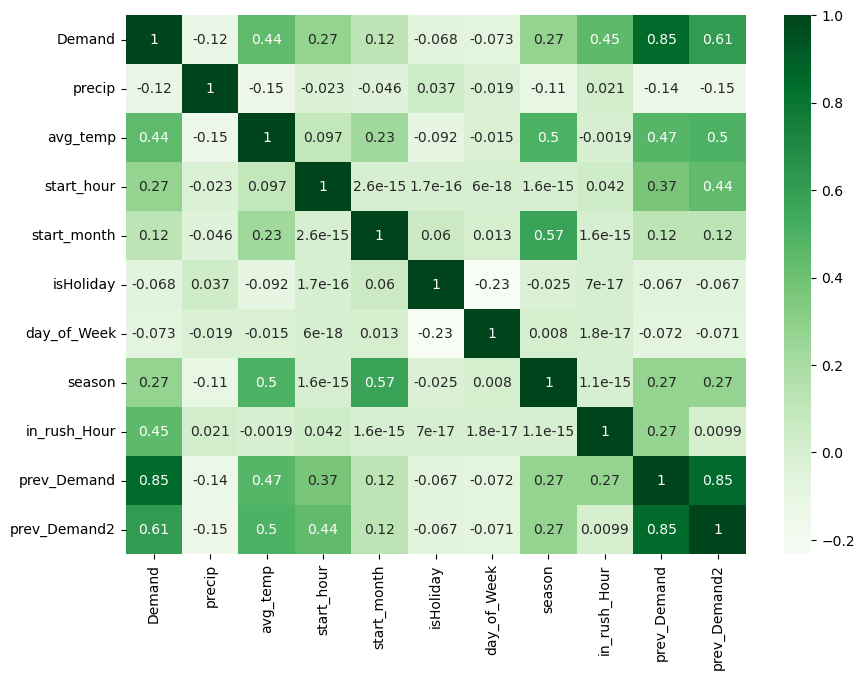

In [381]:
#visualize correlation between features

plt.figure(figsize=(10,7))
sns.heatmap(df_load_weather.corr(), cmap = 'Greens', annot = True)
plt.show()

In [382]:
# Since prev_Demand and prev_Demand2 seem to be highly correlated, we will drop prev_Demand2 as a feature
# Doing this, protects our model from considering unnecessary/redundant features and prevent the performance
# from being harmed

df_load_weather.drop('prev_Demand2', axis = 1, inplace = True)
df_load_weather.head(1)

,start_time,Demand,precip,avg_temp,start_hour,start_month,isHoliday,day_of_Week,season,in_rush_Hour,prev_Demand
0,2018-01-01,7,0.0,-13.9,0,1,1,1,1,0,NaN


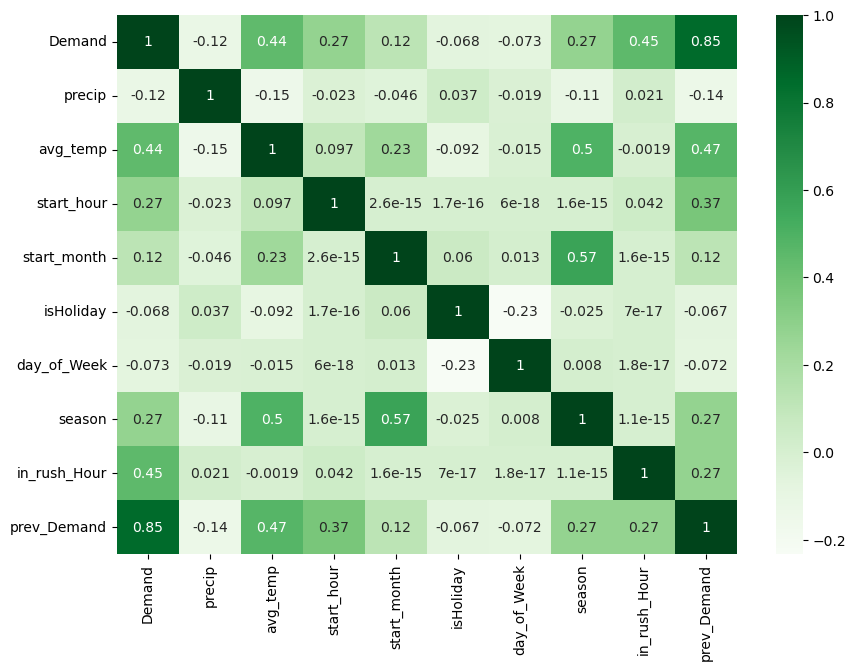

In [383]:
# Show new correlation matrix
plt.figure(figsize=(10,7))
sns.heatmap(df_load_weather.corr(), cmap = 'Greens', annot = True)
plt.show()

In [380]:
# the correlation matrix paints the same picture, as our feature selecting lasso regression earlier

In [384]:
# Regression
# We already have quite the clear picture on how important our features are, based on our Lasso Regression earlier
#test